In [3]:
%cd "d:\Project\urbanlytic 2019"

d:\Project\urbanlytic 2019


In [2]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [4]:
from datetime import datetime

air = pd.read_json("./dataset/air_sensor.json")

air["date_time"] = pd.to_datetime(air["CreatedDateTime"], unit = "s")
air = air.set_index("date_time")

In [9]:
air = air.sort_index()

In [20]:
air_pm25 = air[air["DisplayName"] == "pm25"].copy()
cols = list(air_pm25.columns)
cols.pop(-2)
cols
air_pm25.drop(cols, axis = 1, inplace = True)

In [143]:
# split training and test data

split_date = "2019-06-28"
air_pm25_train = air_pm25.loc[air_pm25.index <= split_date].copy()
air_pm25_test = air_pm25.loc[air_pm25.index > split_date].copy()

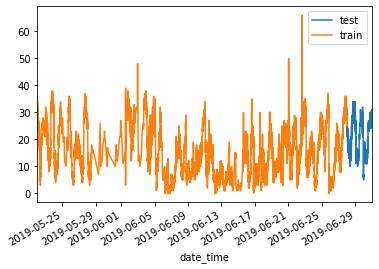

In [144]:
air_pm25_test.rename(columns = {"Value": "test"}).join(air_pm25_train.rename(columns = {"Value": "train"}), how="outer") \
.plot()

In [112]:
def new_features(df, label = None):
    df["date"] = df.index
    df["hour"] = df["date"].dt.hour
    df["dayofweek"] = df["date"].dt.dayofweek
    df["month"] = df["date"].dt.month
    df["dayofyear"] = df["date"].dt.dayofyear
    df["dayofmonth"] = df["date"].dt.day
    
    x = df[["hour", "dayofweek", "month", "dayofyear", "dayofmonth"]]
    
    if label:
        y = df[label]
        return x, y
    return x

In [145]:
x_train, y_train = new_features(air_pm25_train, label = "Value")
x_test, y_test = new_features(air_pm25_test, label = "Value")

In [146]:
reg = xgb.XGBRegressor(n_estimator = 1000, max_depth=3, gamma = 10)
reg.fit(x_train, y_train,
       eval_set=[(x_train, y_train), (x_test, y_test)],
       early_stopping_rounds = 50,
       verbose = True)

[05:28:52] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:15.7233	validation_1-rmse:19.9798
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 50 rounds.
[1]	validation_0-rmse:14.4379	validation_1-rmse:18.455
[2]	validation_0-rmse:13.2946	validation_1-rmse:17.1559
[3]	validation_0-rmse:12.2889	validation_1-rmse:15.9926
[4]	validation_0-rmse:11.3996	validation_1-rmse:14.9129
[5]	validation_0-rmse:10.6087	validation_1-rmse:14.0274
[6]	validation_0-rmse:9.93154	validation_1-rmse:13.2193
[7]	validation_0-rmse:9.33099	validation_1-rmse:12.4473
[8]	validation_0-rmse:8.80833	validation_1-rmse:11.7477
[9]	validation_0-rmse:8.36157	validation_1-rmse:11.468
[10]	validation_0-rmse:7.96362	validation_1-rmse:10.8991
[11]	validation_0-rmse:7.61108	validation_1-rmse:10.3471
[12]	validation_0-rmse:7.31767	validation_1-rmse:9.94

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=10,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimator=1000,
             n_estimators=100, n_jobs=1, nthread=None, objective='reg:linear',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=1, verbosity=1)

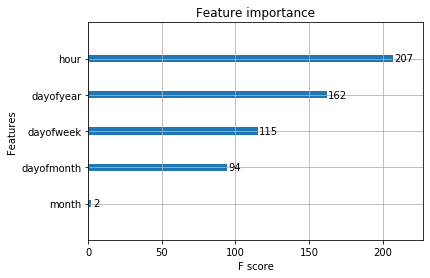

In [128]:
plot_importance(reg)

In [147]:
air_pm25_test["prediction"] = reg.predict(x_test)
air_pm25_all = pd.concat([air_pm25_test, air_pm25_train], sort = False)

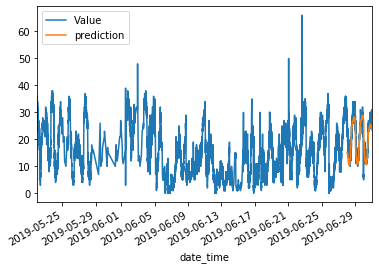

In [148]:
air_pm25_all[["Value", "prediction"]].plot()

In [33]:
def rmse(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.sqrt(np.mean(np.square(y_true - y_pred)))

In [149]:
rmse(air_pm25_test["Value"], air_pm25_test["prediction"])

4.89083662074091

In [160]:
pred = pd.date_range("2019-07-01", "2019-07-08", freq = "H")

In [163]:
pred_df = pd.DataFrame(pred, columns = ["date"])
pred_df["hour"] = pred_df["date"].dt.hour
pred_df["dayofweek"] = pred_df["date"].dt.dayofweek
pred_df["month"] = pred_df["date"].dt.month
pred_df["dayofyear"] = pred_df["date"].dt.dayofyear
pred_df["dayofmonth"] = pred_df["date"].dt.day
pred_df = pred_df.set_index("date")

In [141]:
output = reg.predict(pred_df)

In [142]:
d = pd.DataFrame({"Value":output[:-1]})
d.to_csv("values.csv")